# Interface metrics

In [1]:
import numpy as np
import MDAnalysis as mda

/home/akshay/apps/miniconda3/envs/proteinmpnn_binder_design/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
u = mda.Universe('trimer_relaxed_0001.pdb','trimer_relaxed_0001.pdb')
x = u.select_atoms('chainID A and (around 4 (chainID B or chainID C))')
print(len(np.unique(x.resids)))
#print(np.unique(x.resids))

chA = u.select_atoms('chainID A')
chA_residues = chA.residues.resids
x_unique_residues = np.unique(x.resids)
residues_not_in_x = np.setdiff1d(chA_residues, x_unique_residues)

print(len(chA_residues))
print(len(residues_not_in_x))

114
538
424


In [3]:
remarks = []
for position in residues_not_in_x:
    remark = f"REMARK PDBinfo-LABEL:{position: >5} FIXED"
    remarks.append(remark)

In [6]:
remarks_str = '\n'.join(remarks)
with open('trimer_relaxed_0001_chA.pdb','a') as f:
    f.write('\n')
    f.write(remarks_str)

In [ ]:
! silentfrompdbs trimer_relaxed_0001_chA.pdb > trimer_relaxed_0001_chA.silent

# Bioemu analysis

## Pairwise RMSDs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md 
import MDAnalysis as mda
from MDAnalysis.analysis import rms

In [3]:
u = mda.Universe('bioemu/o_x008/topology.pdb','bioemu/o_x008/samples.xtc')
v = u
x = np.zeros([len(u.trajectory),len(u.trajectory)])
for i in range(0,len(u.trajectory)):
    v.trajectory[i]
    r = rms.RMSD(u,v,select='backbone',ref_frame=i).run()
    x[i,:] = r.rmsd[:,2]

/home/akshay/apps/miniconda3/envs/py311/lib/python3.11/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


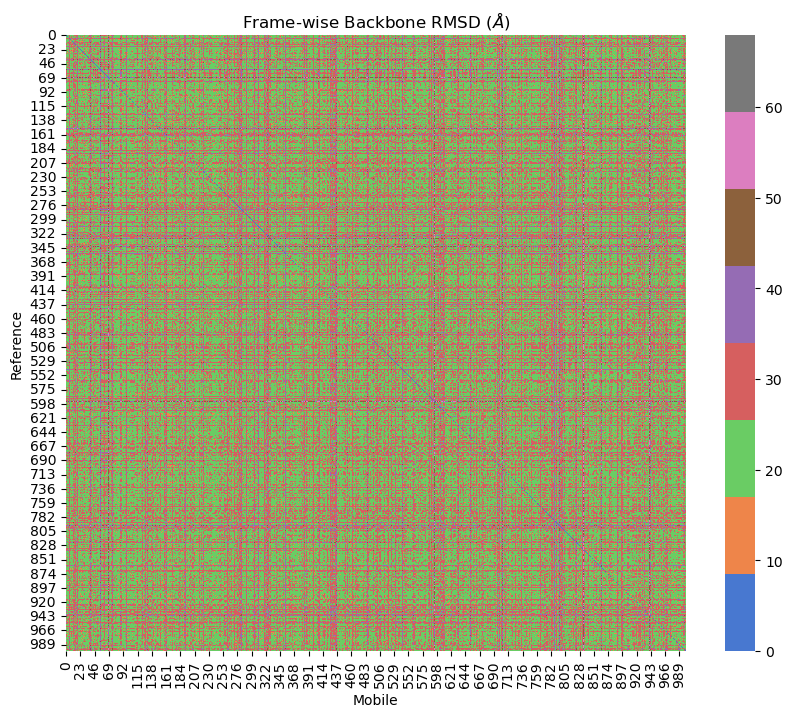

In [4]:
plt.figure(figsize=(10,8))
cmap = sns.color_palette("muted",8)
sns.heatmap(x,cmap=cmap)
plt.xlabel('Mobile')
plt.ylabel('Reference')
plt.title('Frame-wise Backbone RMSD ($\AA$)')
plt.savefig('bioemu/o_x008/rmsd.png',dpi=400,bbox_inches='tight',facecolor='white')

## PCA on trajectory

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md 
import MDAnalysis as mda
from MDAnalysis.analysis import rms
from MDAnalysis.analysis import pca, align

/home/akshay/apps/miniconda3/envs/py311/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [6]:
aligner = align.AlignTraj(u, u, select='backbone',in_memory=True).run()
pc = pca.PCA(u, select='backbone',align=True, mean=None,n_components=None).run()

/home/akshay/apps/miniconda3/envs/py311/lib/python3.11/site-packages/MDAnalysis/analysis/pca.py:337: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Cumulative variance')

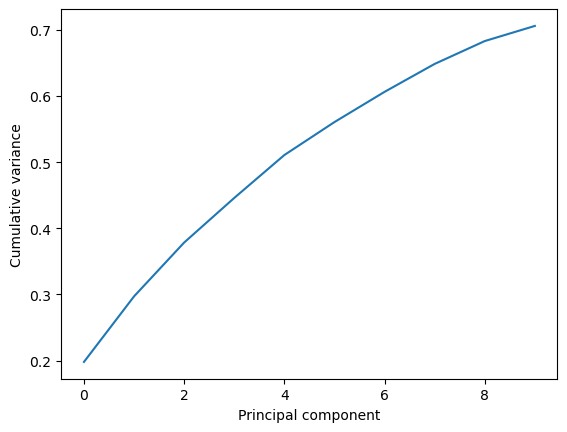

In [7]:
plt.plot(pc.cumulated_variance[:10])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance')

In [8]:
backbone = u.select_atoms('backbone')
transformed = pc.transform(backbone, n_components=3)
transformed.shape

(1000, 3)

In [9]:
import pandas as pd
df = pd.DataFrame(transformed,
                  columns=['PC{}'.format(i+1) for i in range(3)])
df.head()

,PC1,PC2,PC3
0,-215.243267,109.674797,168.842321
1,-274.049537,292.070151,267.885398
2,475.708924,8.351424,94.426744
3,-200.193706,358.947515,-129.135285
4,136.588548,-269.336063,194.866996


/home/akshay/apps/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/akshay/apps/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


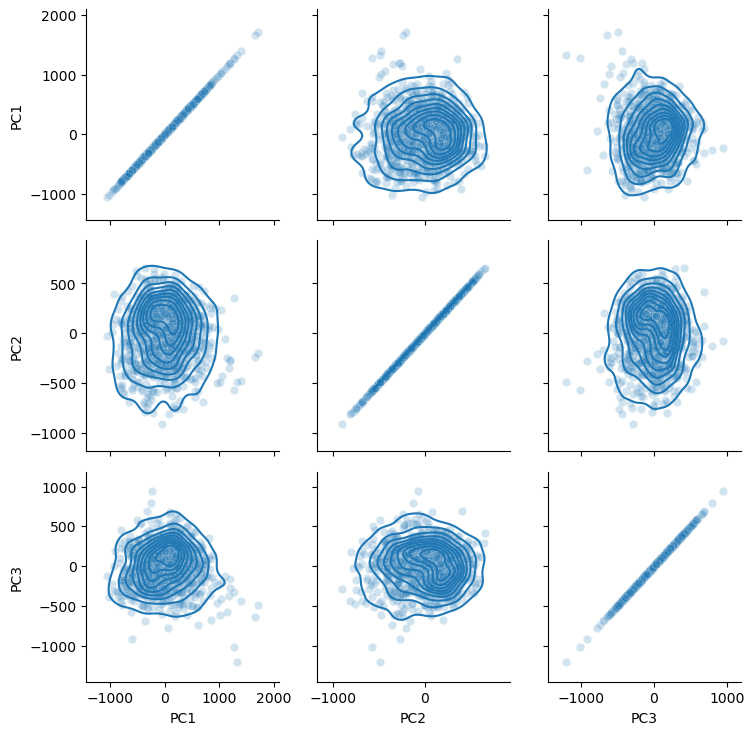

In [10]:
g = sns.PairGrid(df)
g.map(sns.scatterplot,alpha=0.2)
g.map(sns.kdeplot, fill=False)

## Comparison to the monomer from AF3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md 
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSD

9.613454359427557
32.67124203563122


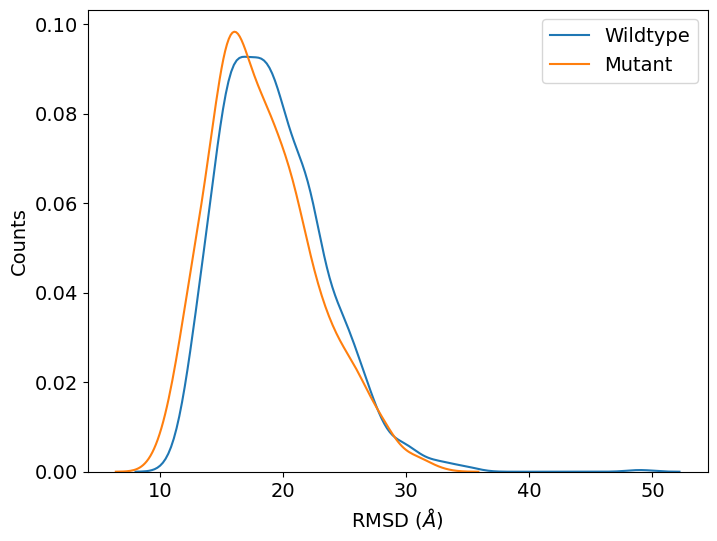

In [44]:
u = mda.Universe('bioemu/wildtype/topology.pdb','bioemu/wildtype/samples.xtc')
v = mda.Universe('trimer_relaxed_0001_chA.pdb','trimer_relaxed_0001_chA.pdb')
w = mda.Universe('bioemu/o_x045/topology.pdb','bioemu/o_x045/samples.xtc')

R = RMSD(u, v, select='backbone and resid 1-460').run()
S = RMSD(w, v, select='backbone and resid 1-460').run() #S = RMSD(w, v, select='backbone and resid 1-350').run()
print(S.results.rmsd[:,2].min())
print(S.results.rmsd[:,2].max())

plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = '14'
#plt.hist(R.results.rmsd[:,2],bins=30,alpha=0.5);
#plt.hist(S.results.rmsd[:,2],bins=30,alpha=0.5);
sns.kdeplot(R.results.rmsd[:,2])
sns.kdeplot(S.results.rmsd[:,2])
plt.xlabel('RMSD ($\AA$)')
plt.ylabel('Counts')
plt.legend(['Wildtype','Mutant'])

In [45]:
np.argmin(R.results.rmsd[:,2])

638

## Comparison of bioemu monomer ensemble to WT monomer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSD

def plot_rmsd(traj):
    u = mda.Universe('bioemu/wildtype/topology.pdb','bioemu/wildtype/samples.xtc')
    v = mda.Universe('trimer_relaxed_0001_chA.pdb','trimer_relaxed_0001_chA.pdb')
    w = mda.Universe(traj+'/topology.pdb',traj+'/samples.xtc')

    R = RMSD(u, v, select='backbone and resid 1-460').run()
    S = RMSD(w, v, select='backbone and resid 1-460').run()

    plt.figure(figsize=(8,6))
    plt.rcParams['font.size'] = '14'
    plt.hist(R.results.rmsd[:,2],bins=30,alpha=0.5);
    plt.hist(S.results.rmsd[:,2],bins=30,alpha=0.5);
    plt.xlabel('RMSD ($\AA$)')
    plt.ylabel('Counts')
    plt.legend(['Wildtype','Mutant'])
    plt.title('RMSD of '+traj)
    plt.savefig(traj+'.png',dpi=400,bbox_inches='tight',facecolor='white')

bioemu/o_x066
bioemu/o_x067
bioemu/o_x068
bioemu/o_x069
bioemu/o_x070
bioemu/o_x071
bioemu/o_x072
bioemu/o_x073
bioemu/o_x074
bioemu/o_x075
bioemu/o_x076
bioemu/o_x077
bioemu/o_x078
bioemu/o_x079
bioemu/o_x080
bioemu/o_x081
bioemu/o_x082
bioemu/o_x083
bioemu/o_x084
bioemu/o_x085
bioemu/o_x086


/tmp/ipykernel_2706348/1674198403.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,6))


bioemu/o_x087
bioemu/o_x088
bioemu/o_x089
bioemu/o_x090
bioemu/o_x091
bioemu/o_x092
bioemu/o_x093
bioemu/o_x094
bioemu/o_x095
bioemu/o_x096
bioemu/o_x097
bioemu/o_x098
bioemu/o_x099
bioemu/o_x100


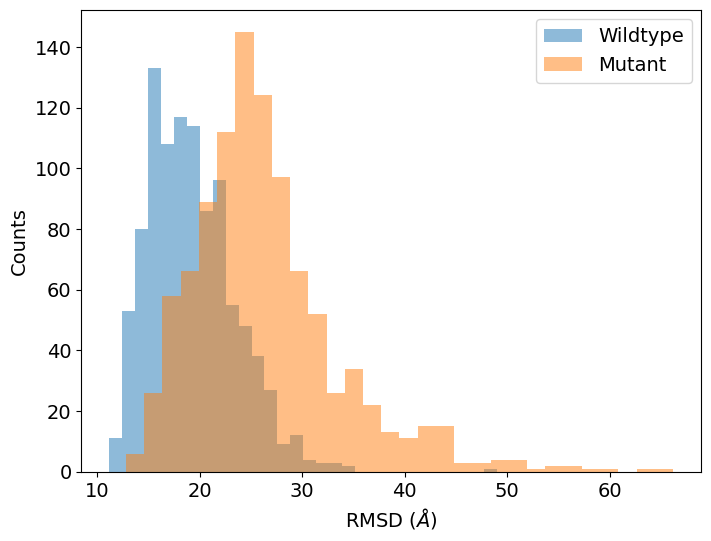

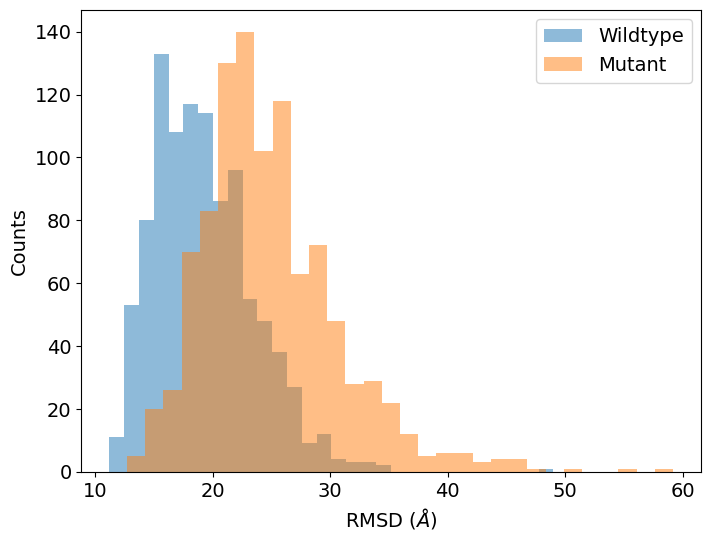

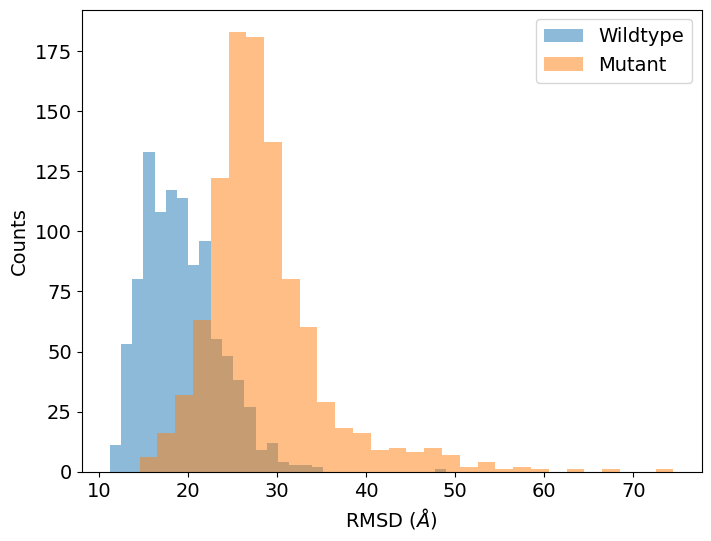

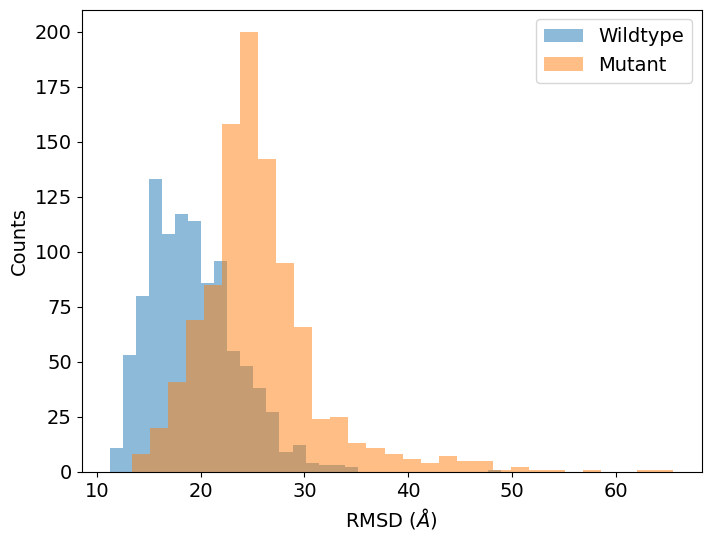

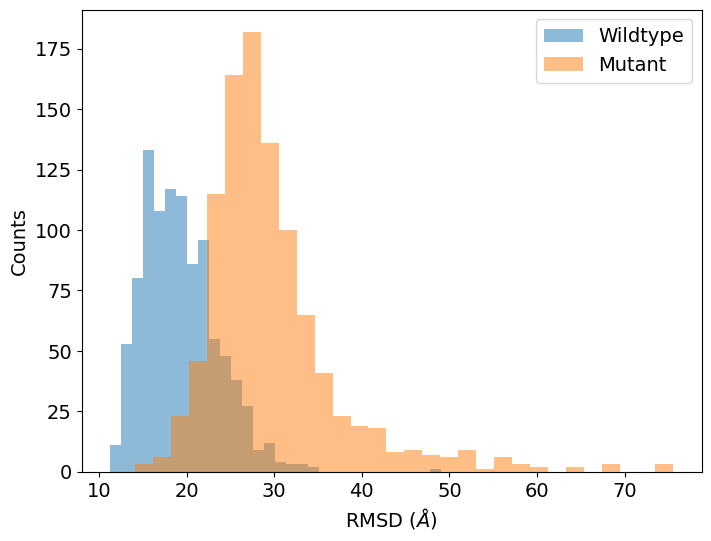

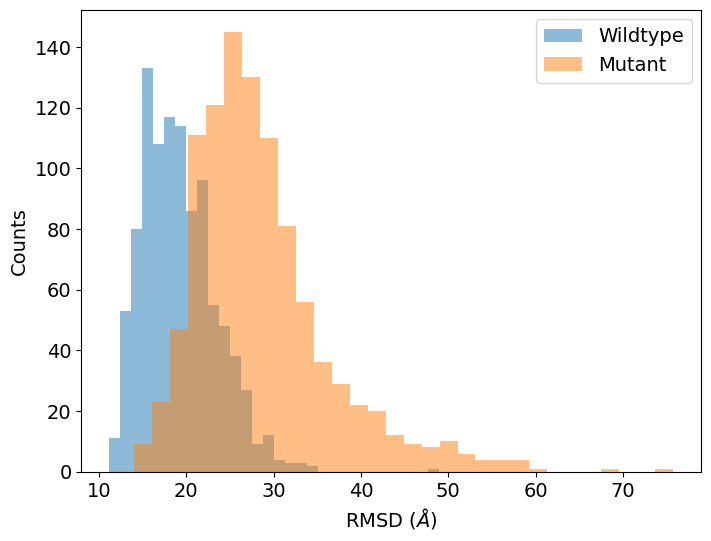

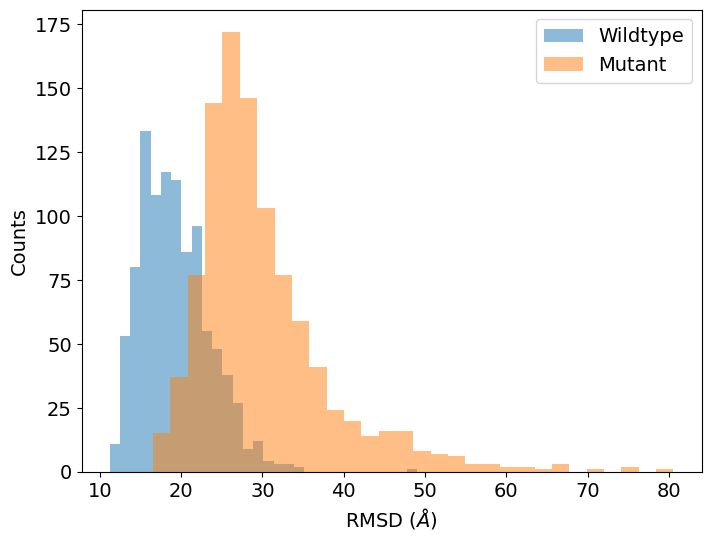

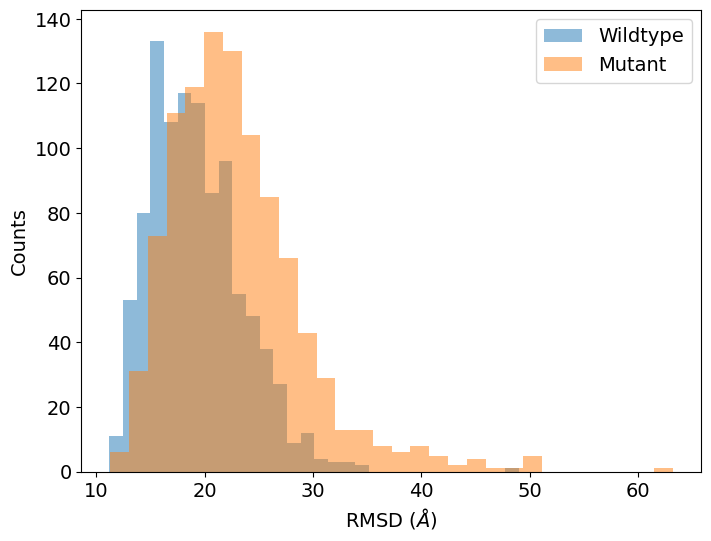

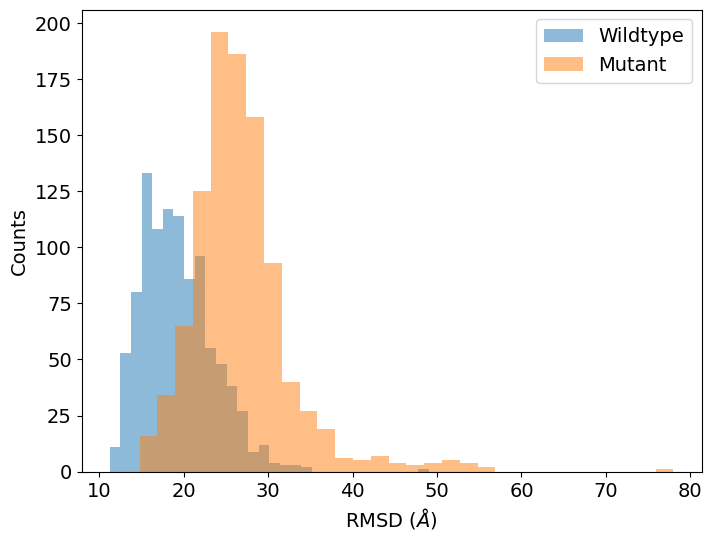

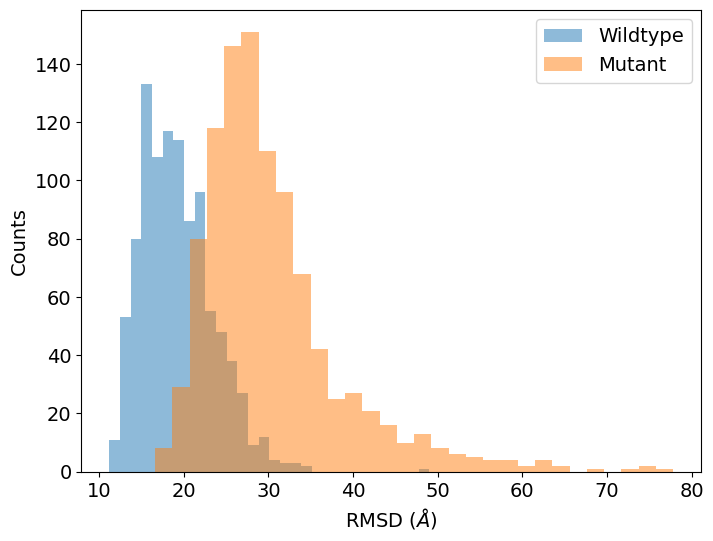

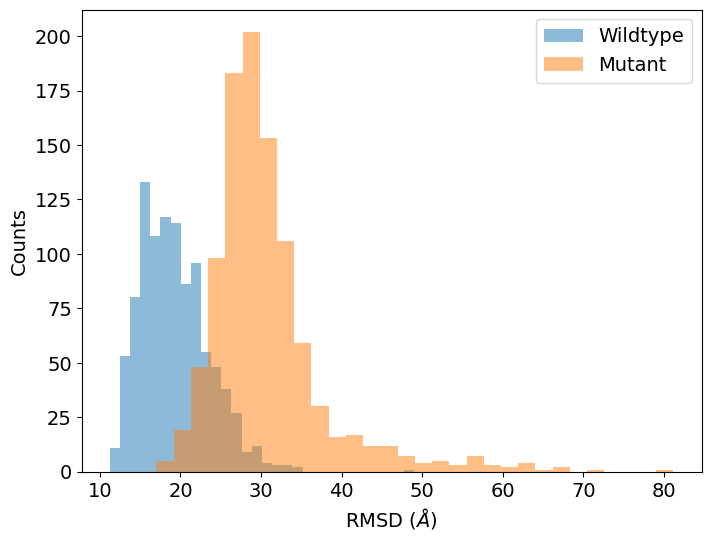

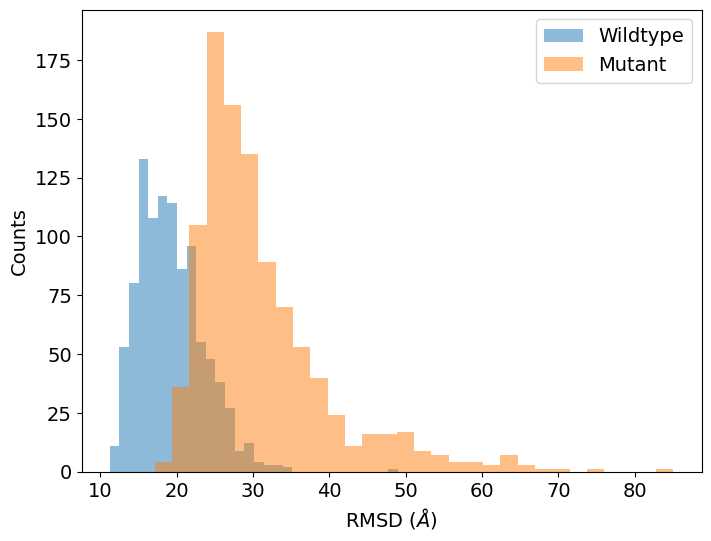

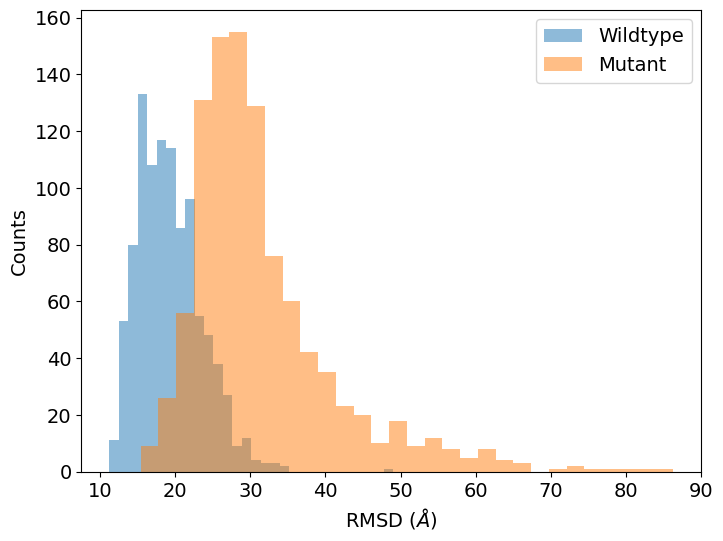

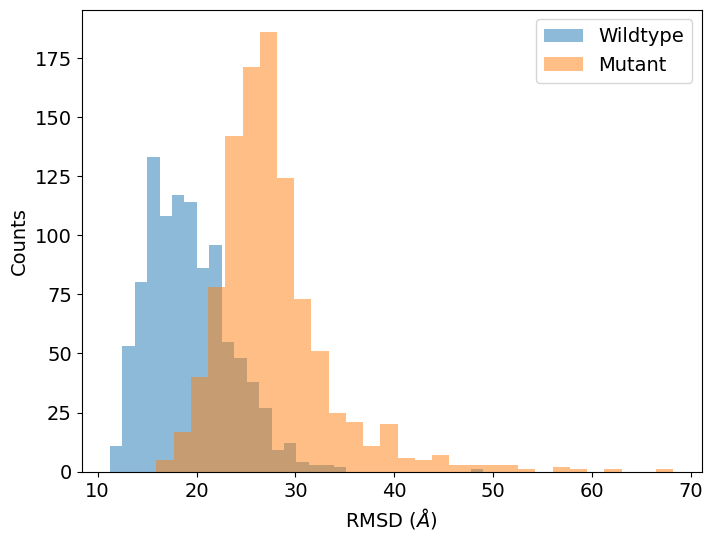

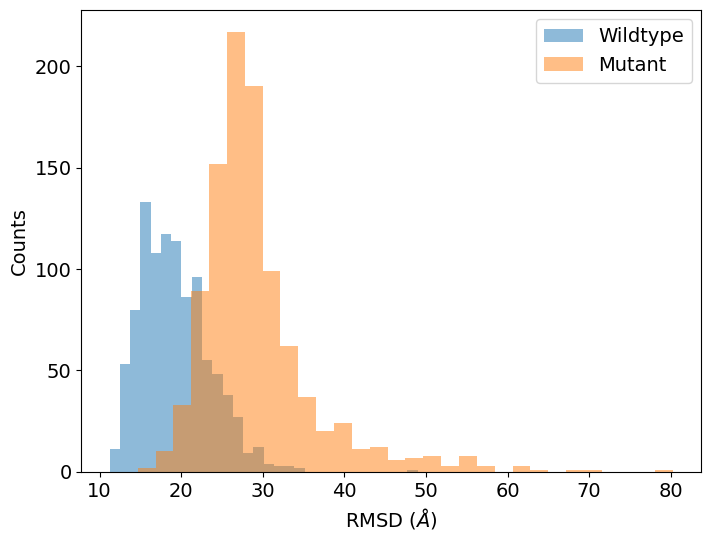

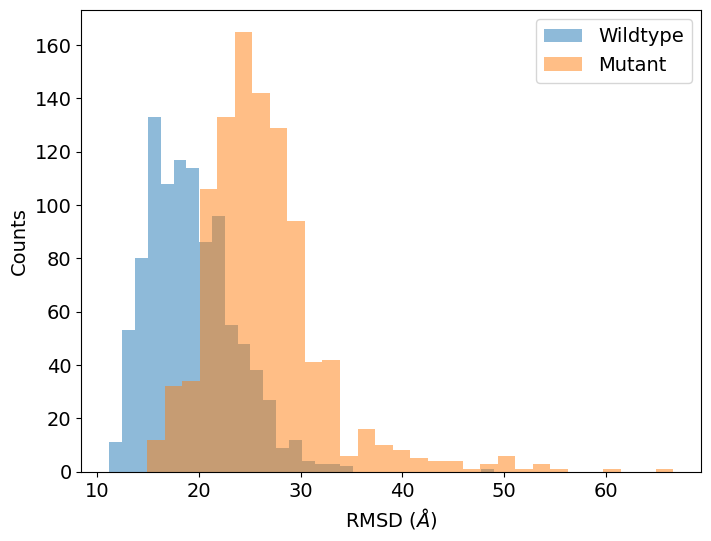

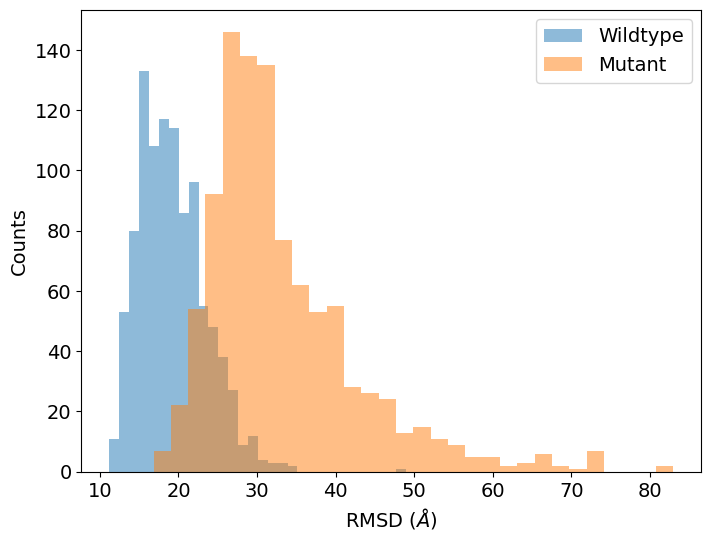

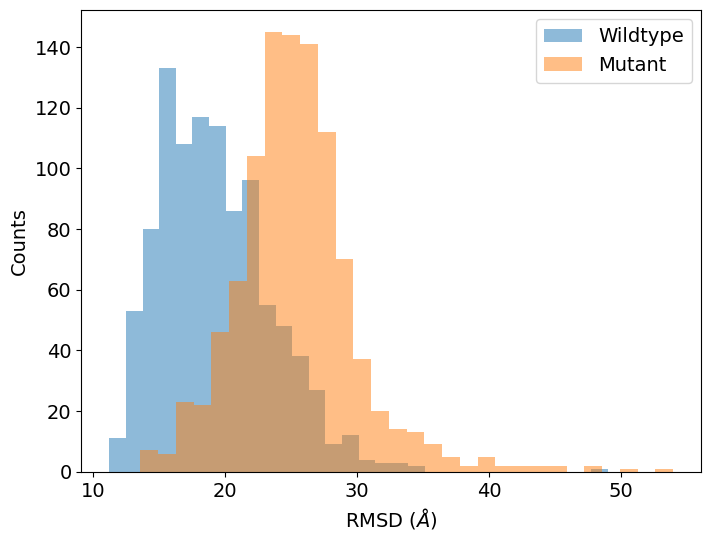

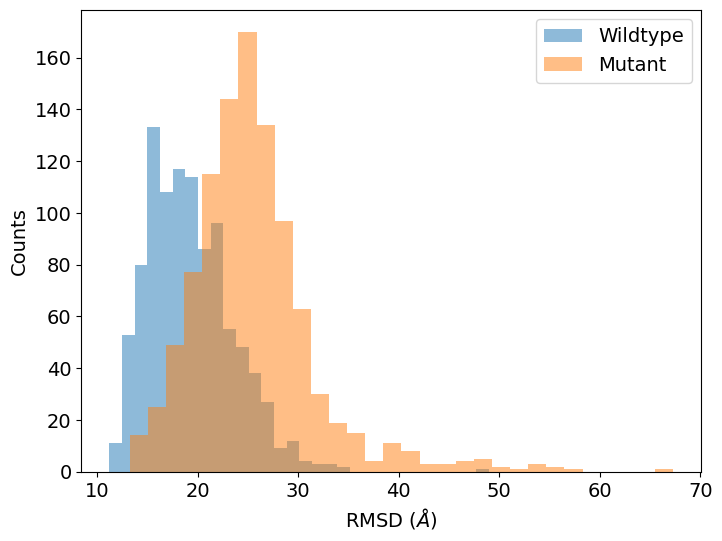

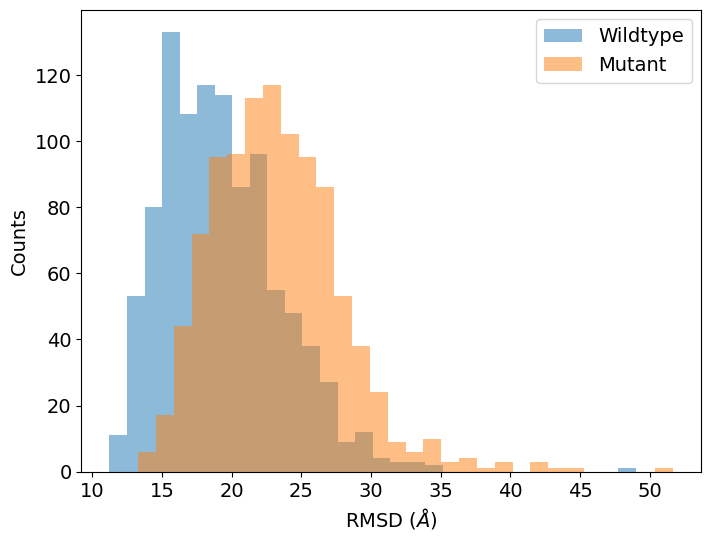

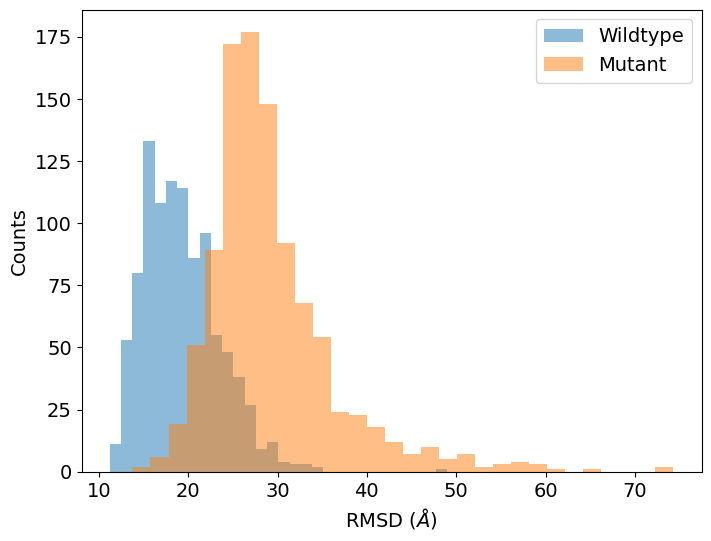

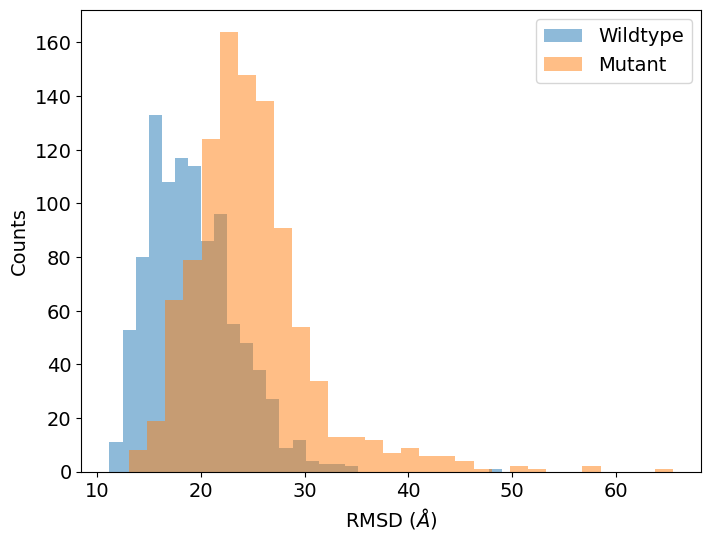

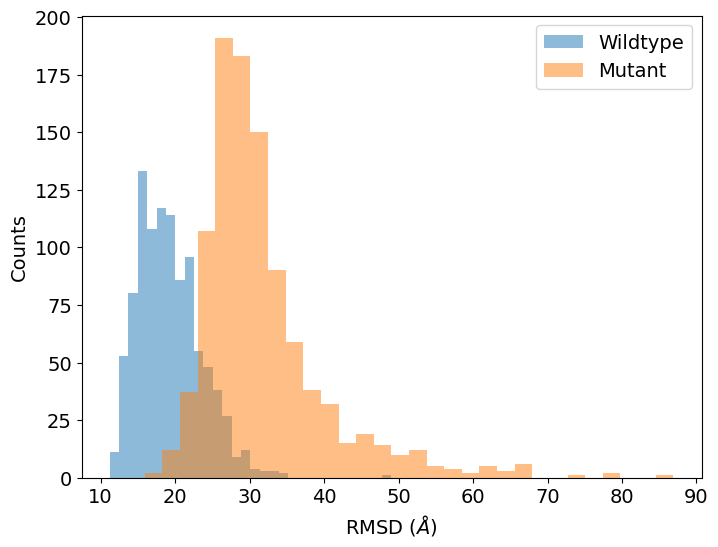

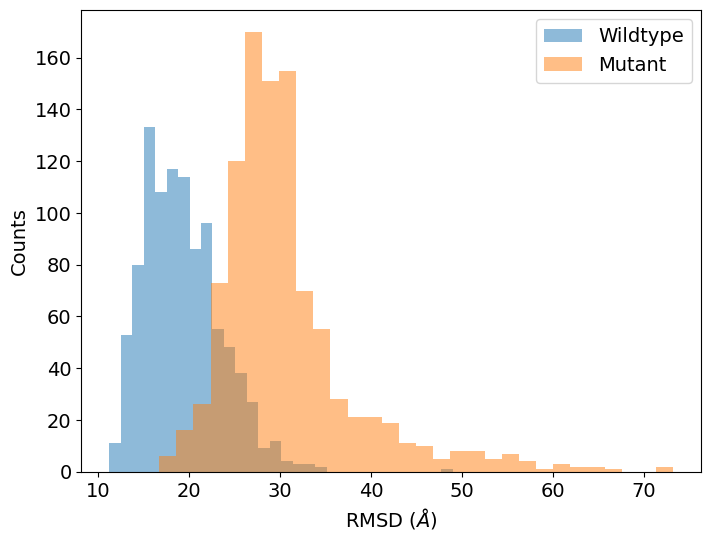

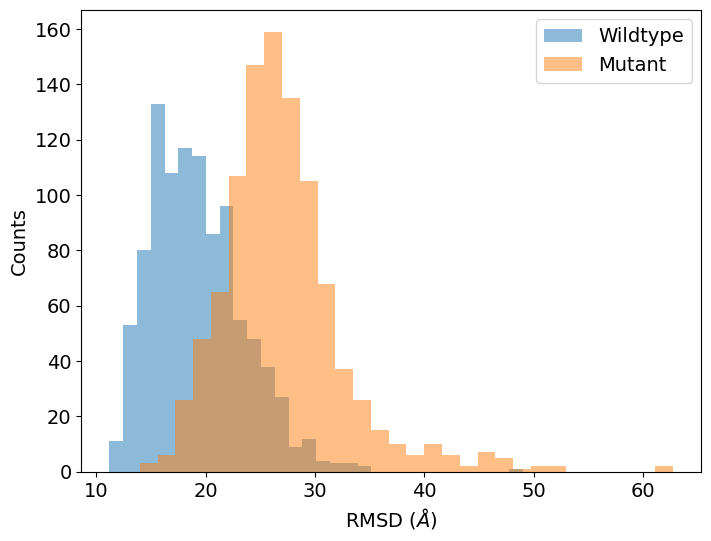

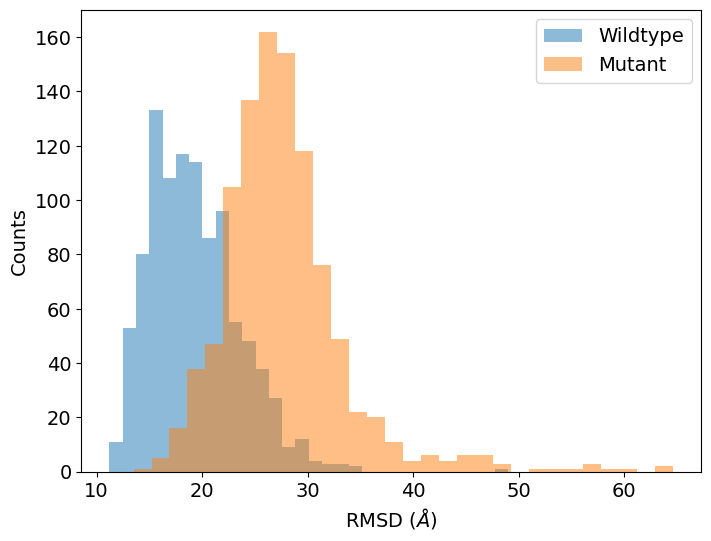

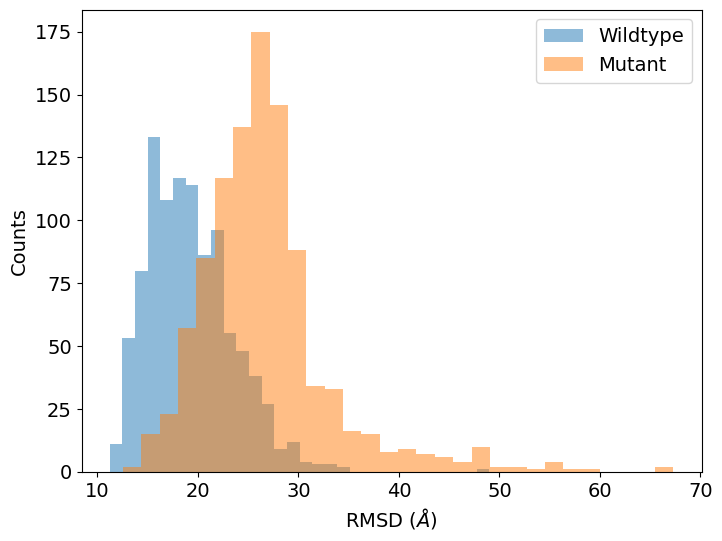

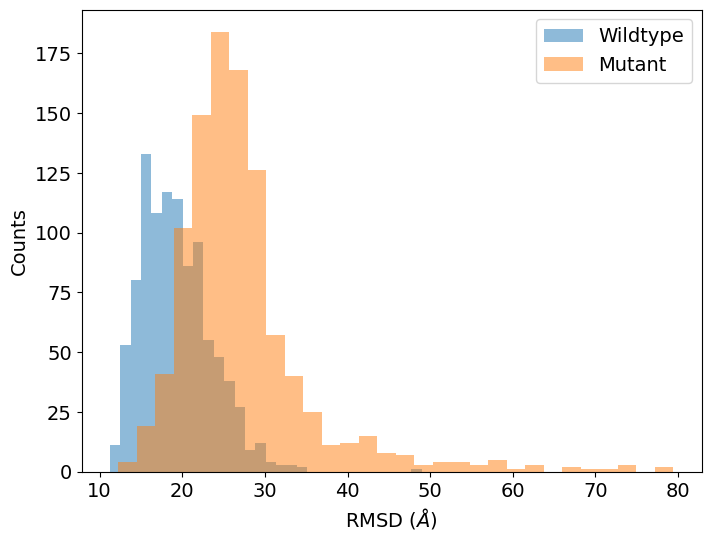

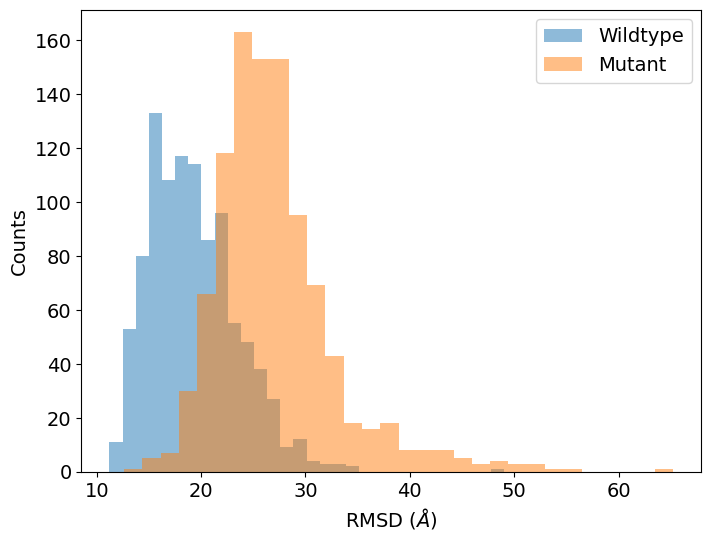

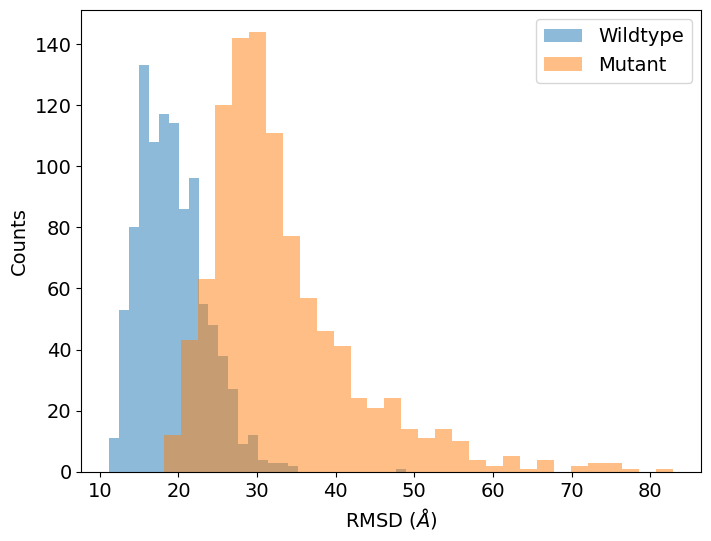

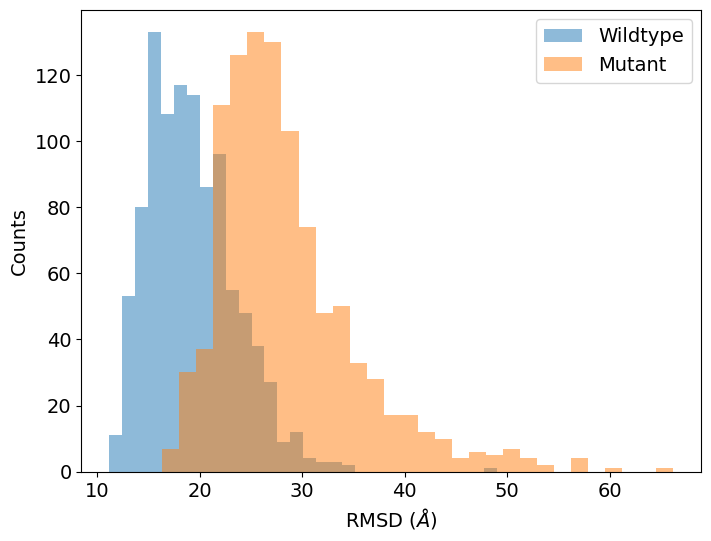

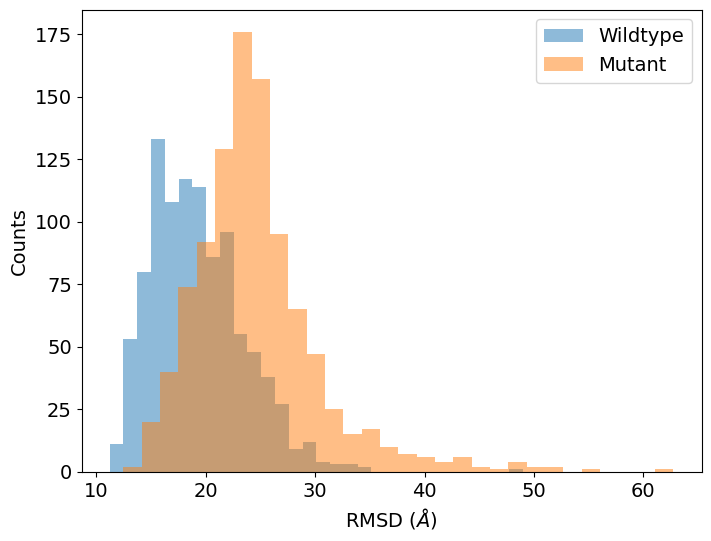

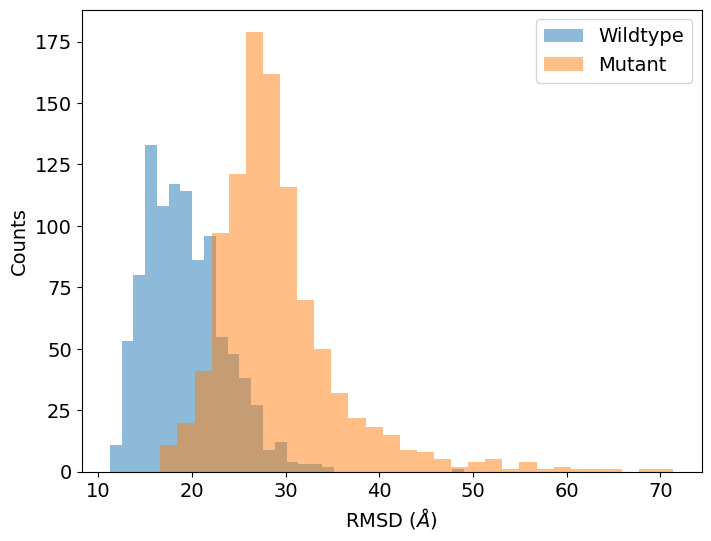

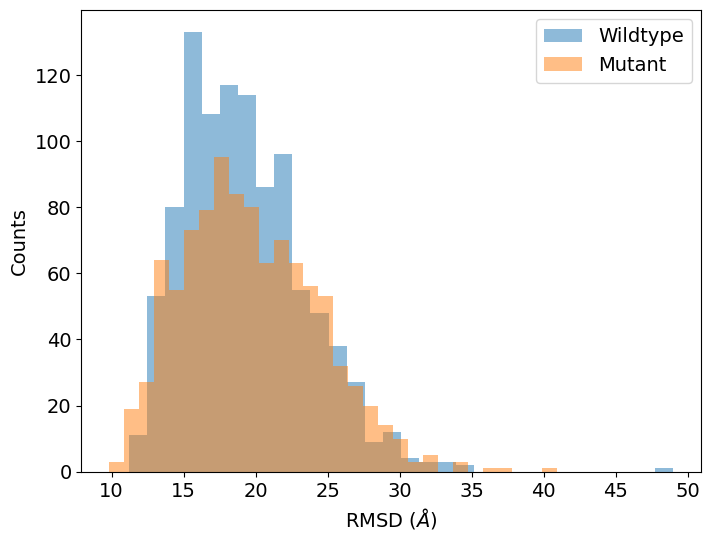

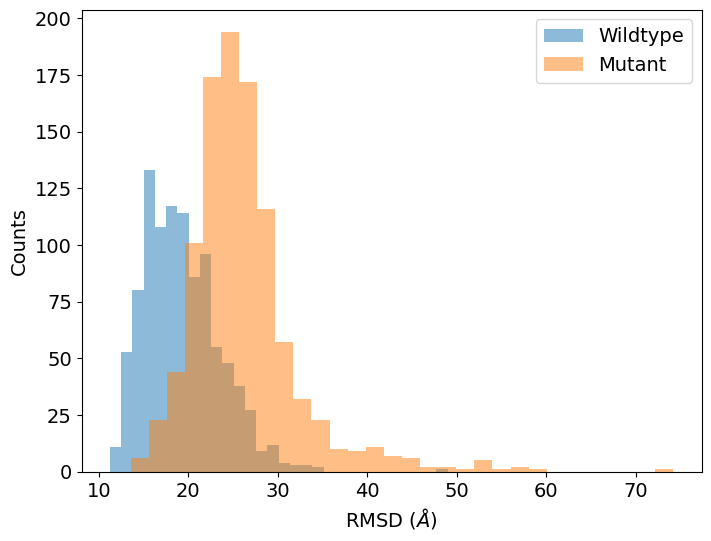

In [5]:
for i in range(66,101):
    w = f'bioemu/o_x{i:03d}'
    print(w)
    plot_rmsd(w)

# Pyrosetta

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyrosetta as py
py.init( "-beta_nov16 -mute all -use_terminal_residues true -mute basic.io.database core.scoring" )

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2025 [Rosetta PyRosetta4.conda.ubuntu.cxx11thread.serialization.Ubuntu.python311.Release 2025.06+release.029c6a159b896477003a14f78f472d4cd2cead46 2025-02-04T15:14:13] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
[ WARNING ] Resetting the global tracer options, which have already

In [18]:
sxfn = py.get_score_function(True)

core.scoring.ScoreFunctionFactory: SCOREFUNCTION: beta_nov16.wts


In [19]:
from pyrosetta.rosetta.core import select

In [20]:
chA = pose.split_by_chain()[1]

core.kinematics.FoldTree: delete_jump_seqpos: deleting jump 1
core.kinematics.FoldTree: delete_jump_seqpos: renumbering jump 2 to 1
core.conformation.Conformation: Found disulfide between residues 4 481
core.conformation.Conformation: Found disulfide between residues 54 57
core.conformation.Conformation: Found disulfide between residues 60 72
core.conformation.Conformation: Found disulfide between residues 94 143
core.conformation.Conformation: Found disulfide between residues 178 272
core.conformation.Conformation: Found disulfide between residues 292 318
core.conformation.Conformation: Found disulfide between residues 488 492
core.kinematics.FoldTree: delete_jump_seqpos: deleting jump 1
core.kinematics.FoldTree: delete_jump_seqpos: renumbering jump 2 to 1
core.conformation.Conformation: Found disulfide between residues 4 481
core.conformation.Conformation: Found disulfide between residues 54 57
core.conformation.Conformation: Found disulfide between residues 60 72
core.conformation.C

In [22]:
from pyrosetta.rosetta.protocols.protein_mpnn import ProteinMPNNMover

In [1]:
import sys
sys.path.append('/home/akshay/apps/dl_binder_design/mpnn_fr/')

In [2]:
from ProteinMPNN.protein_mpnn_utils import ProteinMPNN

In [3]:
ProteinMPNN.unconditional_probs?

Signature:
ProteinMPNN.unconditional_probs(
    self,
    X,
    mask,
    residue_idx,
    chain_encoding_all,
)
Docstring: Graph-conditioned sequence model 
File:      ~/apps/dl_binder_design/mpnn_fr/ProteinMPNN/protein_mpnn_utils.py
Type:      function